In [1]:
import numpy as np
import scipy.stats as ss
import emcee
import time
import scipy
import h5py
from scipy.stats import gaussian_kde, wishart, poisson, norm, multivariate_normal
from scipy.special import logsumexp
from scipy.interpolate import interp1d
import dynesty
from dynesty.utils import resample_equal

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn
import corner
import matplotlib.lines as mlines

In [2]:
params = {'font.family': 'DejaVu Serif',
          'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'xtick.direction':'in',
          'ytick.direction':'in',
          'ytick.labelsize':'large','font.size':19}
plt.rcParams.update(params)
inches_to_cm = 2.54
figsize = (40/inches_to_cm, 13/inches_to_cm)
dpi = 180

### Define Model

In [3]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.rosen.html
def rosen(x):
    """The Rosenbrock function"""
    if len(x.shape) > 1:
        p = np.sum(100*(x[:,1:] - x[:,:-1]**2)**2 + (1 - x[:,:-1])**2, axis=1)
        return -np.array(p)
    else:
        p = sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)
        return -p

#https://git.ligo.org/gregory.ashton/bilby_mcmc_validation/-/blob/master/Rosenbrock/analyse.py
def draw_rosenbrock(limit=5, n_samples=1000000):
    """
    Draw from a 2D Rosenbrock distribution

    This is done by reparameterizing the problem as

    z = 10 (y - x^2)
    w = x - 1

    so that

    lnL = - (w^2 + z^2)
    """
    z = np.random.normal(0, 2 ** -0.5, n_samples * 2)
    w = np.random.normal(0, 2 ** -0.5, n_samples * 2)

    x = w + 1
    y = z / 10 + x ** 2

    keep = (abs(x) < 5) & (abs(y) < 5)

    x = x[keep][:n_samples]
    y = y[keep][:n_samples]
    return x, y

true = draw_rosenbrock()
true = np.transpose(true)

### Sample Using Varaha

In [4]:
from functions import *

In [5]:
# User provided
ndim = 2
maxx = 5
nsel = 1000# number of largest log-likelihood samples selected to estimate lkl_thr for the next cycle.
xrange = np.vstack([[-maxx, maxx]  for ii in range(ndim)]) #Start with a large rectangular bix same as emcee.
xbox = np.array([[0, 1]] * ndim)#Start with a box.
#Sampler
nmc = 40000# Number of samples at which likelihood is calculated in each cycle
allx, allloglkl = np.transpose([[]] * ndim), []
cycle = 1
dx, binunique, nbins, ninbin = {}, {}, {}, {}
dx[cycle] = np.diff(xbox, axis = 1).flatten()
binunique[cycle] = np.array([ndim * [0]]) #There is only one unique bin in the beginning
# The number of samples in each unique bin. There is only one so all samples go there
ninbin[cycle] = nmc
nbins[cycle] = np.ones(ndim)
allx_log_injd = []
neff_varaha = 0
log_V = frac = injneff = Z_jump = 0
log_delta_V = -np.inf
lkl_thr = -np.inf
pinside = 1
t0 = time.time()

while pinside > 0.1:
    
    log_LivV = np.log(binunique[cycle].shape[0]) - np.log(nbins[cycle]).sum()
    x = sample_from_bins(xbox, dx[cycle], binunique[cycle], ninbin[cycle])
    xprior = xrange.T[0] + x * np.diff(xrange).flatten()#map back to original prior
    loglkl = rosen(xprior)
    allx_log_injd, log_injd_x, InsLiveVol = \
            update_injection_density(allx, x, allx_log_injd, xbox, dx, binunique, ninbin, cycle)
    
    allx = np.append(allx, x, axis = 0)
    allloglkl = np.append(allloglkl, loglkl)
    allx_log_injd = np.append(allx_log_injd, log_injd_x)
    
    lw = allloglkl - allx_log_injd
    Z = logsumexp(lw)
    lw -= lw.max()
    w = np.exp(lw)
    neff_varaha = w.sum() ** 2 / (w**2).sum()
    
    print(cycle, rnd(neff_varaha), rnd(np.max(allloglkl), 1), np.exp(log_V), np.exp(log_delta_V-log_V), frac, injneff, pinside)
    cycle += 1
    
    idxsel = np.where(allloglkl >= lkl_thr)
    frac, next_lkl_thr, injneff, pin = get_likelihood_threshold(allloglkl[idxsel], allx_log_injd[idxsel], nsel)
    if frac < 0.9 and np.exp(log_delta_V - log_V) <= 1/np.sqrt(nsel): 
        lkl_thr = next_lkl_thr
        log_V += np.log(frac)
        log_delta_V = log_V - 0.5 * np.log(injneff)
        lw = allloglkl - allx_log_injd
        Z_jump = logsumexp(lw)
        pinside *= pin
    else:
        idxsel = np.where(allloglkl[InsLiveVol] >= lkl_thr)
        log_injw = -allx_log_injd[InsLiveVol]
        injw = np.exp(log_injw - log_injw.max())
        frac = injw[idxsel].sum()/injw.sum()
        injneff = injw[idxsel].sum() ** 2 / (injw[idxsel] ** 2).sum()
        log_V_from_LivV = np.log(frac) + log_LivV
        log_delta_V_from_LivV = log_V_from_LivV - 0.5*np.log(injneff)
        
        #Calculate error weighted mean and the associated error -- improve accuracy on log_V
        log_V = np.logaddexp(log_V - 2*log_delta_V, log_V_from_LivV - 2*log_delta_V_from_LivV)
        log_delta_V = -0.5 * np.logaddexp(-2 * log_delta_V, -2 * log_delta_V_from_LivV)
        log_V += 2 * log_delta_V

    idxsel = np.where(allloglkl >= lkl_thr)
    nsamp = int(injneff + 0.5)
    selx = sample_uniformly_on_cdf(allx[idxsel], allloglkl[idxsel], allx_log_injd[idxsel], nsamp)
        
    mbin = np.exp(-log_delta_V/ndim)
    nbin = np.maximum(1, norm.rvs(loc = mbin, scale = np.sqrt(mbin), size = (100000, ndim))).astype(int)
    nbins[cycle] = nbin[np.argmin(np.abs(nbin.prod(axis=1) - 1/np.exp(log_delta_V)))]
        
    dx[cycle] = np.diff(xbox, axis = 1).flatten() / nbins[cycle]
    binidx = ((selx - xbox.T[0]) / dx[cycle]).astype(int) #bin indexs of the samples
    
    binunique[cycle] = np.unique(binidx, axis = 0)
    ninbin[cycle] = int(nmc // binunique[cycle].shape[0] + 0.5)
    
    if cycle > 500:
        break
allx = xrange.T[0] + allx * np.diff(xrange).flatten()#map back to original prior
print ('Time taken Varaha:', np.round(time.time() - t0, 1))

1 226.7 -0.0 1.0 0.0 0 0 1
2 4446.1 -0.0 0.025 0.03162277660168381 0.025 1000.0 0.9999850588602289
3 10231.7 -0.0 0.024399173156835575 0.007146980084390527 0.44037262663853793 18578.0 0.9999850588602289
4 30649.2 -0.0 0.006353875321071497 0.009498379614145222 0.2604135509113111 11084.113253886459 0.900004564064353
5 56799.0 -0.0 0.0047512173777796915 0.006320763998992751 0.7477668568697159 25030.0 0.8100087225497219
6 89402.3 -0.0 0.003804047553234233 0.005155461133831312 0.8006469186244467 37624.0 0.7290112049375406
7 126034.0 -0.0 0.0031420025429864315 0.0044538680212058805 0.825963003620992 50411.0 0.6561112509726412
8 163656.8 -0.0 0.002645626037067995 0.003992914869211382 0.8420190629614713 62722.00000000002 0.5905053259694454
9 200967.0 -0.0 0.0022567434708990128 0.0036740132615438056 0.8530092459325957 74083.0 0.5314572533915071
10 236595.4 -0.0 0.0019436745359336265 0.0034353715006776985 0.8612740264888545 84733.0 0.4783124242834952
11 268907.3 -0.0 0.0016862206823560716 0.0032

In [6]:
#Marginal likelihood
log_injw = -allx_log_injd 
Z = logsumexp(allloglkl + log_injw)
Zarr = []
idx = np.arange(len(allloglkl))
for ii in range(400):
    idx = np.random.choice(np.arange(len(allloglkl)), replace = False, size = len(allloglkl) // 400)
    Zarr = np.append(Zarr, logsumexp(allloglkl[idx] + log_injw[idx]) + np.log(400))
print (Z, '+/-', np.std(Zarr)/20)
print ('Expected', -5.804)

-5.803410908160636 +/- 0.0011468845276298594
Expected -5.804


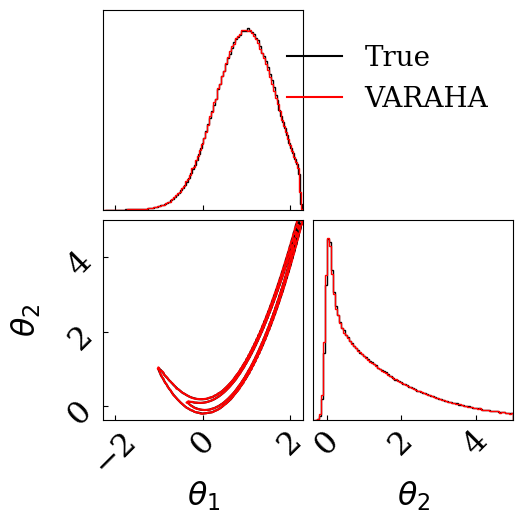

In [7]:
idx = np.where(w > 0.00001)

l=[]
for ii in range(ndim):
    l.append(r'$\theta_{' + str(ii+1) + '}$')
hh = dict(density=True, color = 'black')
figure = corner.corner(true, bins = 100, levels=(1 - np.exp(-2.), 1 - np.exp(-9 / 2.)), plot_density=False, 
                       plot_datapoints=False, color = 'black',labels=l, hist_kwargs=hh, max_n_ticks=5)
hh = dict(density=True, color = 'red')
corner.corner(allx[idx], fig=figure, color='red', bins = 100, levels=(1 - np.exp(-2.), 1 - np.exp(-9 / 2.)), 
              plot_density=False, plot_datapoints=False, weights=w[idx], hist_kwargs=hh, max_n_ticks=3)
plt.legend(handles=[mlines.Line2D([], [], color='black', label='True'), mlines.Line2D([], [], color='red', label='VARAHA')], 
           fontsize=20, frameon=False, bbox_to_anchor=(1, ndim), loc="upper right")

In [8]:
# User provided
ndim = 7
maxx = 5
nsel = 5000# number of largest log-likelihood samples selected to estimate lkl_thr for the next cycle.
xrange = np.vstack([[-maxx, maxx]  for ii in range(ndim)]) #Start with a large rectangular bix same as emcee.
xbox = np.array([[0, 1]] * ndim)#Start with a box.
#Sampler
nmc = 40000# Number of samples at which likelihood is calculated in each cycle
allx, allloglkl = np.transpose([[]] * ndim), []
cycle = 1
dx, binunique, nbins, ninbin = {}, {}, {}, {}
dx[cycle] = np.diff(xbox, axis = 1).flatten()
binunique[cycle] = np.array([ndim * [0]]) #There is only one unique bin in the beginning
# The number of samples in each unique bin. There is only one so all samples go there
ninbin[cycle] = nmc
nbins[cycle] = np.ones(ndim)
allx_log_injd = []
neff_varaha = 0
log_V = frac = injneff = Z_jump = 0
log_delta_V = -np.inf
lkl_thr = -np.inf
pinside = 1
t0 = time.time()

while pinside > 0.1:
    
    log_LivV = np.log(binunique[cycle].shape[0]) - np.log(nbins[cycle]).sum()
    x = sample_from_bins(xbox, dx[cycle], binunique[cycle], ninbin[cycle])
    xprior = xrange.T[0] + x * np.diff(xrange).flatten()#map back to original prior
    loglkl = rosen(xprior)
    allx_log_injd, log_injd_x, InsLiveVol = \
            update_injection_density(allx, x, allx_log_injd, xbox, dx, binunique, ninbin, cycle)
    
    allx = np.append(allx, x, axis = 0)
    allloglkl = np.append(allloglkl, loglkl)
    allx_log_injd = np.append(allx_log_injd, log_injd_x)
    
    lw = allloglkl - allx_log_injd
    Z = logsumexp(lw)
    lw -= lw.max()
    w = np.exp(lw)
    neff_varaha = w.sum() ** 2 / (w**2).sum()
    
    print(cycle, rnd(neff_varaha), rnd(np.max(allloglkl), 1), np.exp(log_V), np.exp(log_delta_V-log_V), frac, injneff, pinside)
    cycle += 1
    
    idxsel = np.where(allloglkl >= lkl_thr)
    frac, next_lkl_thr, injneff, pin = get_likelihood_threshold(allloglkl[idxsel], allx_log_injd[idxsel], nsel)
    if frac < 0.9 and np.exp(log_delta_V - log_V) <= 1/np.sqrt(nsel): 
        lkl_thr = next_lkl_thr
        log_V += np.log(frac)
        log_delta_V = log_V - 0.5 * np.log(injneff)
        lw = allloglkl - allx_log_injd
        Z_jump = logsumexp(lw)
        pinside *= pin
    else:
        idxsel = np.where(allloglkl[InsLiveVol] >= lkl_thr)
        log_injw = -allx_log_injd[InsLiveVol]
        injw = np.exp(log_injw - log_injw.max())
        frac = injw[idxsel].sum()/injw.sum()
        injneff = injw[idxsel].sum() ** 2 / (injw[idxsel] ** 2).sum()
        log_V_from_LivV = np.log(frac) + log_LivV
        log_delta_V_from_LivV = log_V_from_LivV - 0.5*np.log(injneff)
        
        #Calculate error weighted mean and the associated error -- improve accuracy on log_V
        log_V = np.logaddexp(log_V - 2*log_delta_V, log_V_from_LivV - 2*log_delta_V_from_LivV)
        log_delta_V = -0.5 * np.logaddexp(-2 * log_delta_V, -2 * log_delta_V_from_LivV)
        log_V += 2 * log_delta_V

    idxsel = np.where(allloglkl >= lkl_thr)
    nsamp = int(injneff + 0.5)
    selx = sample_uniformly_on_cdf(allx[idxsel], allloglkl[idxsel], allx_log_injd[idxsel], nsamp)
        
    mbin = np.exp(-log_delta_V/ndim)
    nbin = np.maximum(1, norm.rvs(loc = mbin, scale = np.sqrt(mbin), size = (100000, ndim))).astype(int)
    nbins[cycle] = nbin[np.argmin(np.abs(nbin.prod(axis=1) - 1/np.exp(log_delta_V)))]
        
    dx[cycle] = np.diff(xbox, axis = 1).flatten() / nbins[cycle]
    binidx = ((selx - xbox.T[0]) / dx[cycle]).astype(int) #bin indexs of the samples
    
    binunique[cycle] = np.unique(binidx, axis = 0)
    ninbin[cycle] = int(nmc // binunique[cycle].shape[0] + 0.5)
    
    if cycle > 500:
        break
allx = xrange.T[0] + allx * np.diff(xrange).flatten()#map back to original prior
print ('Time taken Varaha:', np.round(time.time() - t0, 1))

1 1.0 -442.0 1.0 0.0 0 0 1
2 1.0 -171.3 0.12500000000000003 0.014142135623730958 0.125 5000.0 1.0
3 1.0 -171.3 0.1260172559049977 0.007849110298121147 0.154557463672391 11232.0 1.0
4 1.0 -171.3 0.03769155338363876 0.014140931320174197 0.2990983505628292 5000.851679999967 1.0
5 1.0 -171.3 0.018132973849785395 0.014141730496333866 0.4810885257293907 5000.286480639811 1.0
6 1.0 -171.3 0.010658103011665901 0.01414193353875931 0.5877746860475423 5000.142898716749 1.0
7 1.0 -85.1 0.00694053927151794 0.014141101035885624 0.6511983665311853 5000.731644366894 1.0
8 1.0 -85.1 0.004301228309231891 0.014140878795000771 0.619725375934828 5000.888830603327 1.0
9 1.4 -83.5 0.002869290352892546 0.014141880964405421 0.6670862708529276 5000.1800761999575 1.0
10 1.4 -83.5 0.0015617797740665436 0.01414097379864538 0.5443087251494454 5000.821635645463 1.0000000000000002
11 1.0 -79.2 0.0009100474233775114 0.014141038918424602 0.5826989428912505 5000.775577975598 1.0000000000000004
12 1.0 -41.7 0.00048969357

In [9]:
#Marginal likelihood
log_injw = -allx_log_injd 
Z = logsumexp(allloglkl + log_injw)
Zarr = []
idx = np.arange(len(allloglkl))
for ii in range(100):
    idx = np.random.choice(np.arange(len(allloglkl)), replace = False, size = len(allloglkl) // 400)
    Zarr = np.append(Zarr, logsumexp(allloglkl[idx] + log_injw[idx]) + np.log(400))
print (Z, '+/-', np.std(Zarr)/20)
print ('Dynesty:', '-29.131 +/-  0.073') 

-29.058833831712242 +/- 0.0024382356747004053
Dynesty: -29.131 +/-  0.073


In [10]:
fname = 'files/rosenbrock_7d_nlive10000_walks200.hdf5'
with h5py.File(fname, 'r') as inp:
    ns_weights = inp['weights'][()]
    ns_x = inp['x'][()]

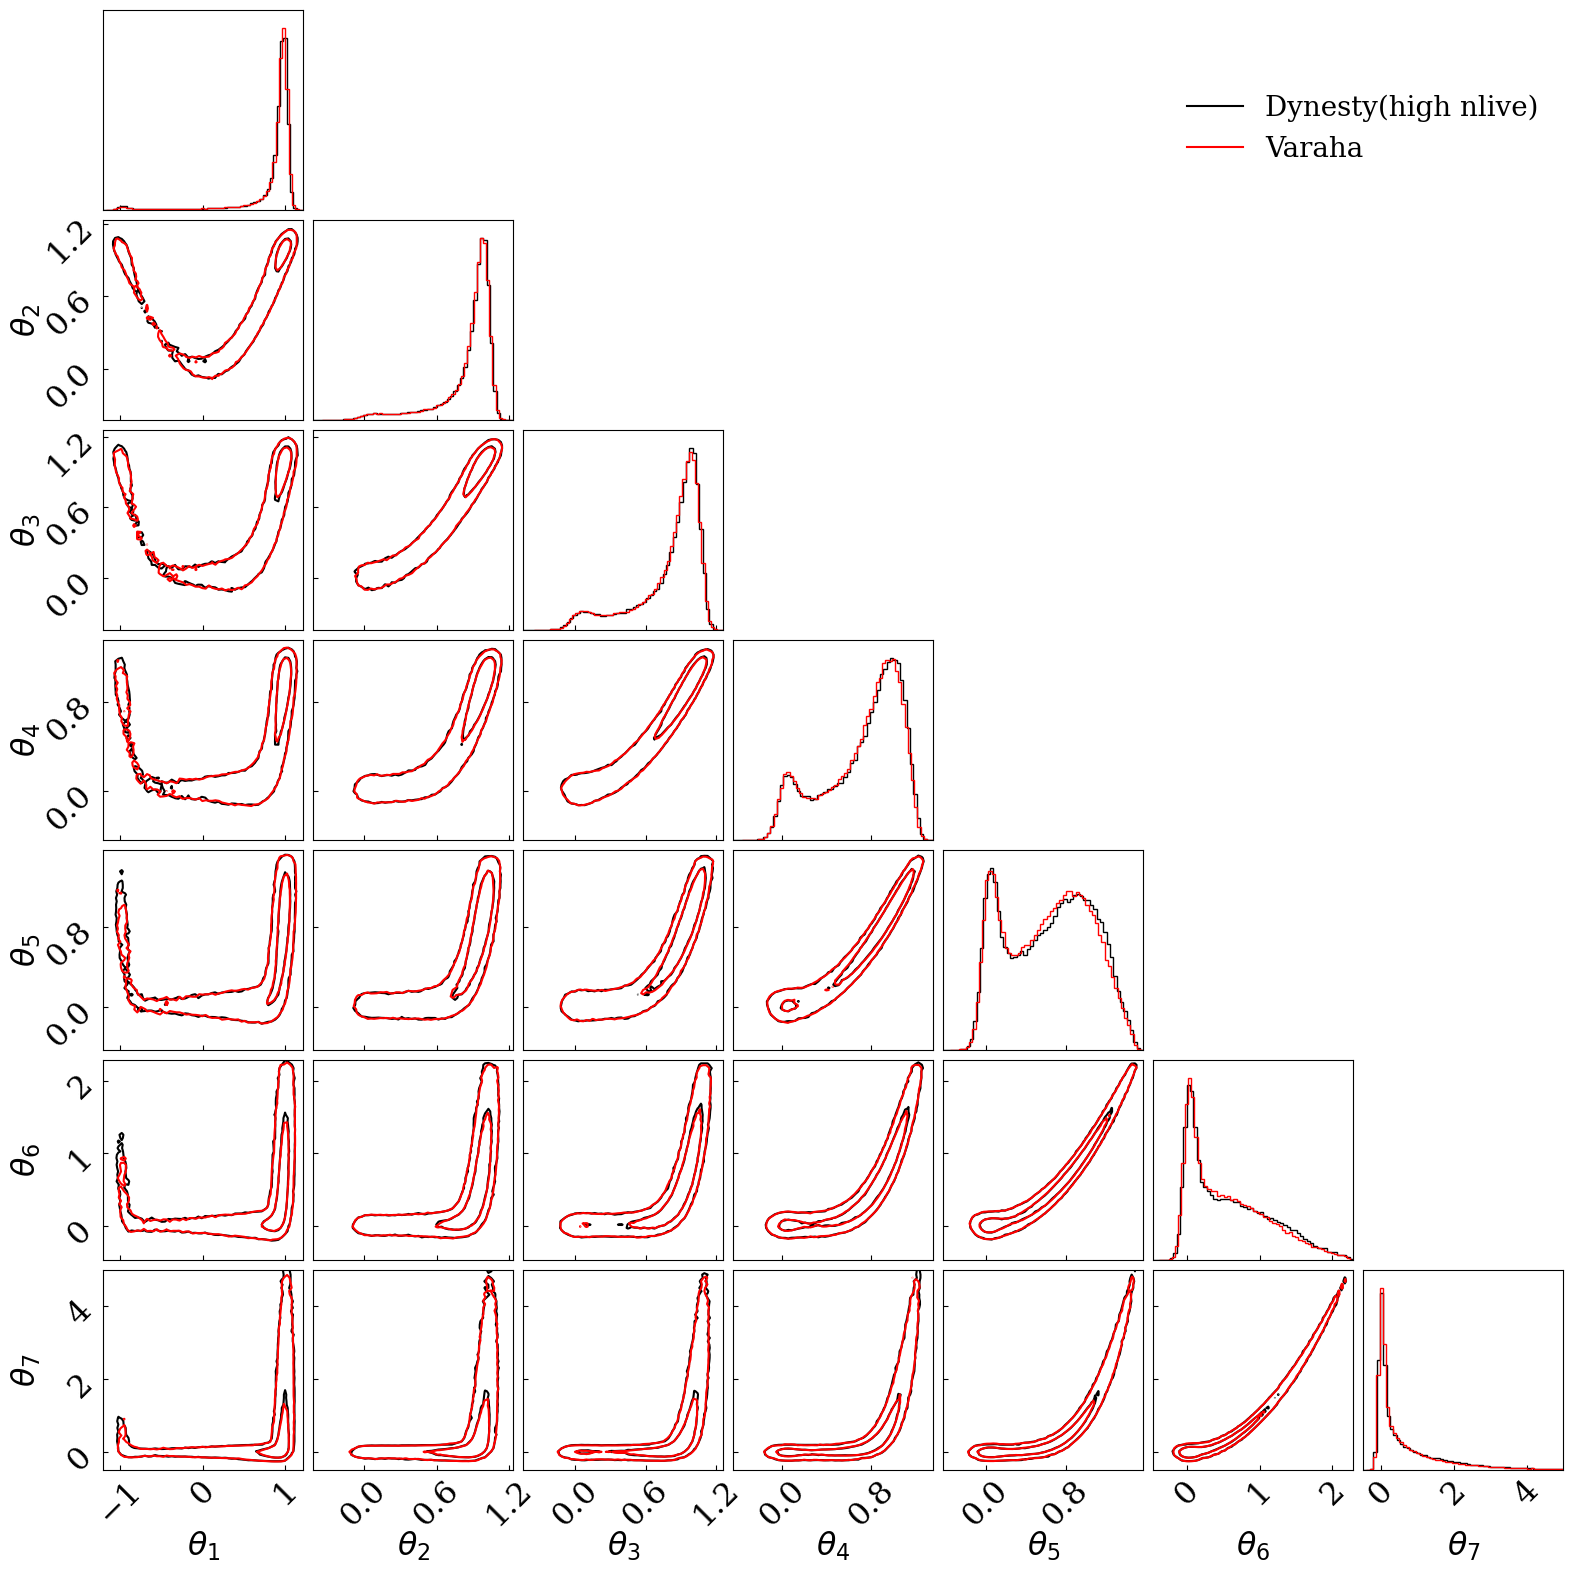

In [11]:
idx = np.where(w > 0.00001)

l=[]
for ii in range(ndim):
    l.append(r'$\theta_{' + str(ii+1) + '}$')
    
hh = dict(density=True, color = 'k')
figure = corner.corner(ns_x, weights=ns_weights, color='k', bins = 60, levels=(1 - np.exp(-1),
                    1 - np.exp(-4)), plot_density=False, plot_datapoints=False, hist_kwargs=hh, density=True)
    
hh = dict(density=True, color = 'red')
corner.corner(allx[idx], fig=figure, color='red', bins = 60, levels=(1 - np.exp(-1.), 1 - np.exp(-4)), 
              plot_density=False, plot_datapoints=False, weights=w[idx], hist_kwargs=hh, max_n_ticks=3, labels=l)

plt.legend(handles=[mlines.Line2D([], [], color='k', label='Dynesty(high nlive)'), mlines.Line2D([], [], color='red', 
    label='Varaha')], fontsize=20, frameon=False, bbox_to_anchor=(1, ndim), loc="upper right")

plt.savefig('files/rosenbrock.jpg', dpi = 200., bbox_inches  = 'tight')